<a href="https://colab.research.google.com/github/foxtrotmike/AS/blob/master/AS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

254,
252,253,
249,250,248,251,
239,246,243,245,244,240,247,
191,230,225,219,217,241,232,242,
69,169,177,210,213,62,178,192,231,224,221,
70,71,87,88,172,119,197,61,49,160,198,203,179,
147,157,50,58,0,1,34,35,
93,94,123,144,
124,125,
####
[  0  34  50  58  61  71  87  94 119 124]
####
N: 128
Positives: 10.0
Tests: 60


ZeroDivisionError: ignored

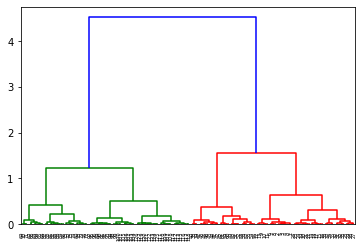

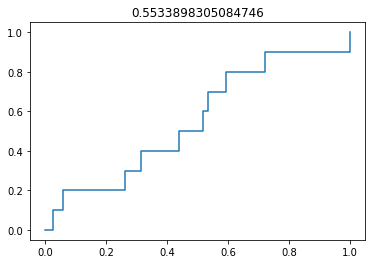

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  2 17:32:46 2020
np.array_split(idx, 2**v)
@author: fayya
"""

import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import collections
from sklearn.metrics import roc_auc_score, roc_curve
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

def getChildrenLeaves(T):
    if T.is_leaf():
        return T.id
    return (getChildrenLeaves(T.left),getChildrenLeaves(T.right))

def flatten(l):
    for el in l:
        if isinstance(el, collections.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
from collections import deque
    
def BFT(node,L):
    node.level = 1
    queue = deque([node])
    output = []
    current_level = node.level
    n_tests = 0
    while len(queue)>0:

          current_node = queue.popleft()
          n_tests+=1
          if(current_node.level > current_level):
              output.append("\n")
              current_level += 1

          output.append(str(current_node.id)+',')

          if current_node.left is not  None:
             current_node.left.level = current_level + 1 
             if current_node.left.is_leaf() or np.any(L[list(flatten(getChildrenLeaves(current_node.left)))]):                 
                 queue.append(current_node.left) 
                 

          if current_node.right is not None:
             current_node.right.level = current_level + 1 
             if current_node.right.is_leaf() or np.any(L[list(flatten(getChildrenLeaves(current_node.right)))]):
                 queue.append(current_node.right)                 
 
    return n_tests,''.join(output)

def simulate(N,p,n):
    L = 1.0*(np.random.rand(N)<p) #original "unknown" labels (positive or negative)       
    #Belief Settings
    if n>=0:
        B = L+0    
        B[L==1]+=n*np.random.randn(np.sum(L==1))
        B[L==0]+=n*np.random.randn(np.sum(L==0))
    else:
        B = np.random.rand(N)
        
    B = (B-np.min(B))/(np.max(B)-np.min(B))
    idx = list(range(len(L)))
    idx = np.argsort(B)    
    B,L = B[idx], L[idx]

    X = np.atleast_2d(B).T
    
    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
    
    model = model.fit(X)
    #plt.title('Hierarchical Clustering Dendrogram')
    #plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    #plt.show()
    # plot the top three levels of the dendrogram
    Z = plot_dendrogram(model, truncate_mode='level', p=-1)
    R, nodelist = hierarchy.to_tree(Z, rd=True)      
    
    #CC = getChildrenLeaves(R)
    
    n_tests,out = BFT(R,L)
    auc = roc_auc_score(L,B)
    
    debug = True
    if debug:
        print(out)
        print('####')
        print(np.nonzero(L)[0])
        print('####')
        print("N:",N)
        print("Positives:",np.sum(L))
        print("Tests:",n_tests)
        bins=np.linspace(-5,5,20)
        hp,bp = np.histogram(B[L==1],bins=bins,density=True)
        hn,bn = np.histogram(B[L==0],bins=bins,density=True)
        bins=bins[:-1]
        #plt.figure();plt.plot(bins,hp,'r-');plt.plot(bins,hn,'b-');plt.show()    
        fpr, tpr, thresholds = roc_curve(L, B)        
        plt.figure();plt.plot(fpr,tpr);plt.title(str(auc))
        1/0
    D = list(flatten([[int(n) for n in z.split(',') if len(n)] for z in out.split('\n')]))
    assert len(set(np.nonzero(L)[0]).difference(D))==0 #ensure that all are tested
    assert len(D)==n_tests #ensure that all are tested
    return n_tests, auc, np.sum(L)
    
if __name__=='__main__':
    plt.close('all')
    trials = 10
    N =int(2**7)    
    n = -0.50
    Z = []
    for p in np.linspace(0.1,0.41,15):
        z = []
        for _ in range(trials):
            T, auc,P = simulate(N,p,n)
            z.append((N,p,n,auc,P,T))
        Z.append(z)
    Z = np.array(Z)
    auc = [np.mean(z[:,-3]) for z in Z]
    x = [np.mean(z[:,1]) for z in Z]
    xx = [round(xx,3) for xx in x]
    y = [np.mean(z[:,-1]) for z in Z]
    data = [z[:,-1] for z in Z]
    fig = plt.figure()    
    plt.plot(xx,y,'o-')
    plt.plot(xx,[N]*len(xx))
    plt.legend(['T','N'])
    locs, labels = plt.xticks() 
    plt.boxplot(data, positions=xx, widths = 0.02,notch=False)
    plt.xticks(xx)
    plt.axis('tight')
    plt.grid()#
    
    plt.xlim(min(xx)-0.05, max(xx)+0.05)
    plt.xlabel('$p$')
    plt.ylabel('$T$')
    plt.title('auc: '+str(round(np.mean(auc),2)))
    plt.show()

    
